<h2>CS 3780/5780 Creative Project: </h2>
<h3>Emotion Classification of Natural Language</h3>

Names and NetIDs for your group members:
Gregor Guerrier - gg429
Andrew Shim - ks875
Neeraj Parihar - np473


<h3>Introduction:</h3>

<p> The creative project is about conducting a real-world machine learning project on your own, with everything that is involved. Unlike in the programming projects 1-5, where we gave you all the scaffolding and you just filled in the blanks, you now start from scratch. The past programming projects provide templates for how to do this (and you can reuse part of your code if you wish), and the lectures provide some of the methods you can use. So, this creative project brings realism to how you will use machine learning in the real world.  </p>

The task you will work on is classifying texts to human emotions. Through words, humans express feelings, articulate thoughts, and communicate our deepest needs and desires. Language helps us interpret the nuances of joy, sadness, anger, and love, allowing us to connect with others on a deeper level. Are you able to train an ML model that recognizes the human emotions expressed in a piece of text? <b>Please read the project description PDF file carefully and follow the instructions there. Also make sure you write your code and answers to all the questions in this Jupyter Notebook </b> </p>
<p>


<h2>Part 0: Basics</h2><p>

<h3>0.1 Import:</h3><p>
Please import necessary packages to use. Note that learning and using packages are recommended but not required for this project. Some official tutorial for suggested packacges includes:
    
https://scikit-learn.org/stable/tutorial/basic/tutorial.html
    
https://pytorch.org/tutorials/
    
https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
<p>

In [ ]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

<h3>0.2 Accuracy and Mean Squared Error:</h3><p>
To measure your performance in the Kaggle Competition, we are using accuracy. As a recap, accuracy is the percent of labels you predict correctly. To measure this, you can use library functions from sklearn. A simple example is shown below. 
<p>

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = [3, 2, 1, 0, 1, 2, 3]
y_true = [0, 1, 2, 3, 1, 2, 3]
accuracy_score(y_true, y_pred)

<h2>Part 1: Basic</h2><p>
Note that your code should be commented well and in part 1.4 you can refer to your comments.

<h3>1.1 Load and preprocess the dataset:</h3><p>
We provide how to load the data on Kaggle's Notebook.
<p>

In [ ]:
train = pd.read_csv("/kaggle/input/cs-3780-5780-how-do-you-feel/train.csv")
train_text = train["text"]
train_label = train["label"]

test = pd.read_csv("/kaggle/input/cs-3780-5780-how-do-you-feel/test.csv")
test_id = test["id"]
test_text = test["text"]

# Sentences using sklearn's vectorizer
feature_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,5))
vectorized_train_text = feature_vectorizer.fit_transform(train_text).toarray()
vectorized_test_text = feature_vectorizer.transform(test_text).toarray()
# Split the vectorized data into training and testing data
x1_train, x1_test, y1_train, y1_test = train_test_split(vectorized_train_text, train_label, test_size=0.2, random_state=42)


split_processed_train_text = []
# Split each string into its words and remove special characters
for sentence in train_text:
    words = re.sub(r'[^a-zA-Z0-9\s]', '', sentence).lower().split()
    split_processed_train_text.append(words)

split_processed_test_text = []
# Split each string into its words and remove special characters
for sentence in test_text:
    words = re.sub(r'[^a-zA-Z0-9\s]', '', sentence).lower().split()
    split_processed_test_text.append(words)

    

x2_train, x2_test, y2_train, y2_test = train_test_split(split_processed_train_text, train_label, test_size=0.2, random_state=42)

<h3>1.2 Use At Least Two Training Algorithms from class:</h3><p>
You need to use at least two training algorithms from class. You can use your code from previous projects or any packages you imported in part 0.1.

In [ ]:
# Support Vector Model
svm_model = SVC(kernel='linear', C=1)

# Naive Bayes
class NaiveBayes:
    # Initialize the model such that we have an alpha to use for words not in the training
    def __init__(self, alpha = 1.0, k = None):
        self.alpha = float(alpha)
        self.k = k

    def fit(self, X, y):
        val = np.array(X, dtype=object)
        lab = np.array(y, dtype=object)
        # Make sure we correctly input processed sentences and labels
        assert(len(val) == len(lab))

        # Get the probability of eacfh emotion
        self.emotion_prob = np.zeros(28)
        for label in y:
            self.emotion_prob[label] += 1
        self.emotion_prob /= np.sum(self.emotion_prob)

        # Get the number of times a word appears in a sentence for each emotion 0-27
        self.word_occurances_per_emotion = {}
        for i in range(0, len(val)):
            for word in val[i]:
                if word in self.word_occurances_per_emotion:
                    self.word_occurances_per_emotion[word][lab[i]] += 1
                else:
                    self.word_occurances_per_emotion[word] = np.zeros(28)
                    self.word_occurances_per_emotion[word][lab[i]] += 1

        # Sum up the number of times a word appears in a sentence for each emotion
        # This gives us the total number of words that appear per emotion
        self.total_words_per_emotion = np.zeros(28)
        for word in self.word_occurances_per_emotion:
            self.total_words_per_emotion += (self.word_occurances_per_emotion[word])

        if self.k is not None:
            word_totals = {word: sum(counts) for word, counts in self.word_occurances_per_emotion.items()}
            sorted_words = sorted(word_totals.items(), key=lambda item: item[1], reverse=True)
            self.word_occurances_per_emotion = {word: self.word_occurances_per_emotion[word] for word, _ in sorted_words[:self.k]}
            
        
    
    def predict(self, X):
        val = np.array(X, dtype=object)
        # Get vocab size
        vocabSize = len(self.word_occurances_per_emotion)
        y = []
        for sentence in val:
            if len(sentence) == 0:
                y.append(-1)
                continue
            
            sentence_emotion_prob = np.zeros(28)
            for i in range(0, 28):
                sentence_emotion_prob[i] = np.log(self.emotion_prob[i])
                for word in sentence:
                    if word in self.word_occurances_per_emotion:
                        sentence_emotion_prob[i] += np.log((self.word_occurances_per_emotion[word][i] + self.alpha) / (self.total_words_per_emotion[i] + vocabSize))
                    else:
                        sentence_emotion_prob[i] += np.log((self.alpha) / (self.total_words_per_emotion[i] + vocabSize))
            y.append(np.argmax(sentence_emotion_prob))
        return np.array(y)
    

# Finding the probabilities for Naive-Bayes
nb_model = NaiveBayes(alpha=0.1, k=2630)


<h3>1.3 Training, Validation and Model Selection:</h3><p>
You need to split your data to a training set and validation set or performing a cross-validation for model selection.

In [ ]:
# Training the SVM
svm_model.fit(x1_train, y1_train)
# Using the trained SVM to predict test values
y1_pred = svm_model.predict(x1_test)
accuracy_score(y1_test, y1_pred)

In [ ]:
# Getting probabilities from naive bayes
nb_model.fit(x2_train, y2_train)
# Getting predictions according to the prior probabilities in naive bayes
y2_pred = nb_model.predict(x2_test)
accuracy_score(y2_test, y2_pred)

<h3>1.4 Explanation in Words:</h3><p>
    You need to answer the following questions in the markdown cell after this cell:

#### 1.4.1 How did you formulate the learning problem?
We first had to understand that we needed to classify strings into one of 28 emotional categories based on their contents. This meant we needed to find a classification algorithm
#### 1.4.2 Which two learning methods from class did you choose and why did you made the choices?
We used **SVM classification** and **Naive Bayes**. \
\
**SVMs** are suited for data fitting and predicting data with a lot of dimensions which we had due to our usage of vectors. We utilized the linear kernal due to its efficiency, and because it handled the data the best.\
\
**Naive Bayes** was used because it was more efficient than SVMs (not more accurate) and we could utilize the probabilistic nature of our emotional classifications.
#### 1.4.3 How did you do the model selection?
We first tuned the parameters to find the ones that provided the most accuracy. This was done using a matrix of values for **Naive Bayes** (k and alpha) and an list of values for **SVMs**. Then we compared the resulting accuracy after training and prediction on the same split data set. This resulted in us coming to the conclusion that the **SVM** was more effective in its predictions.
#### 1.4.4 Does the test performance reach the first baseline "Tiny Piney"? (Please include a screenshot of Kaggle Submission) 
**Tiny Piney** has a score of **0.65**

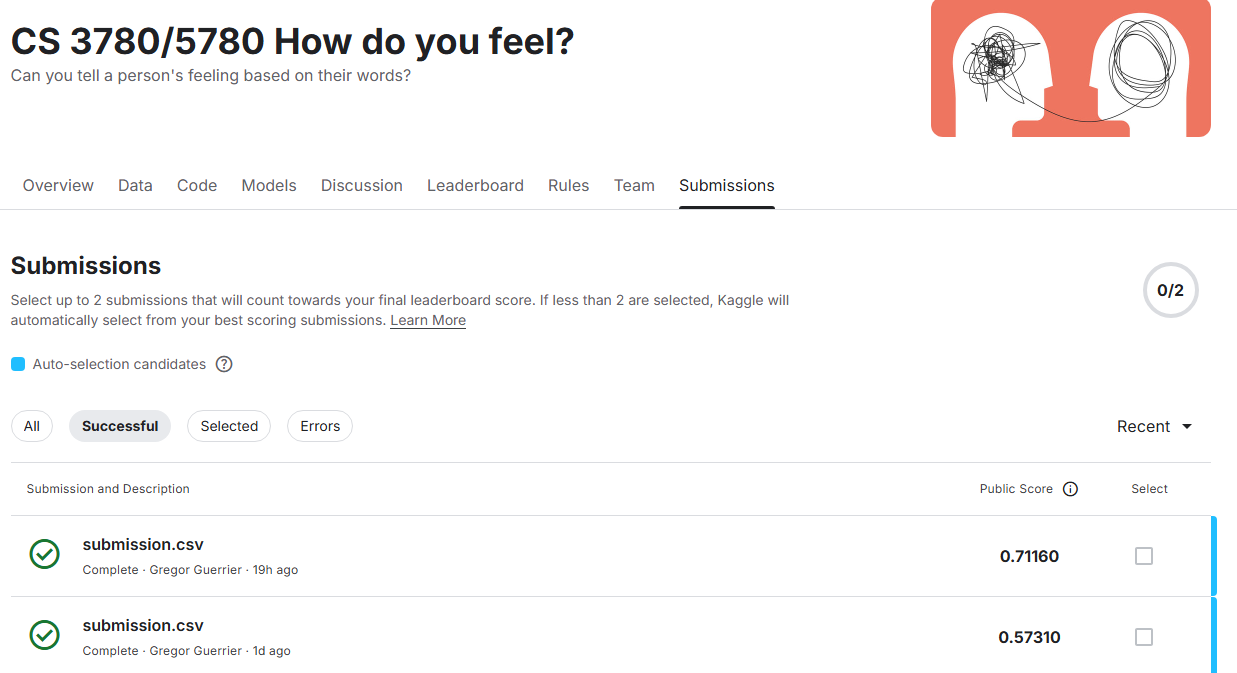 \
\
The top most score is that of the **SVM**, the bottom most score is that of the **Naive Bayes** model

<h2>Part 2: Be creative!</h2><p>

<h3>2.1 Open-ended Code:</h3><p>
You may follow the steps in part 1 again but making innovative changes like using new training algorithms, etc. Make sure you explain everything clearly in part 2.2. Note that beating "Zero Hero" is only a small portion of this part. Any creative ideas will receive most points as long as they are reasonable and clearly explained.

In [14]:
# FOR CREATIVE PART, GETTING SOME ISSUES WHILE RUNNING ON KAGGLE, 
# WORKS FINE WHILE RUNNING ON COLLAB
# PLEASE TRY ON GOOGLE COLLAB

In [ ]:
# Make sure you comment your code clearly and you may refer to these comments in the part 2.2
# TODO

!pip install transformers datasets torch scikit-learn

In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd

# Check and use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


#while testing with collab need to change the path to = 'train.csv' and upload the file there
data = pd.read_csv('/kaggle/input/cs-3780-5780-how-do-you-feel/train.csv')

# Spliting into train and test sets (80-20 split)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

#created new files for further reference 
train_data.to_csv('train_split.csv', index=False)
test_data.to_csv('test_split.csv', index=False)


dataset = DatasetDict({
    'train': load_dataset('csv', data_files='train_split.csv', split='train'),
    'test': load_dataset('csv', data_files='test_split.csv', split='train')
})

print("Train labels:", set(dataset['train']['label']))
print("Test labels:", set(dataset['test']['label']))

Using device: cpu


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Train labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}
Test labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}


In [ ]:
#using Bert Tokenizer Model fro generating tokenized dataset. 
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") # gives error on kaggle, but works fine with collab

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [8]:

print("Train label range:", min(dataset['train']['label']), max(dataset['train']['label']))
print("Test label range:", min(dataset['test']['label']), max(dataset['test']['label']))

Train label range: 0 27
Test label range: 0 27


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=28).to(device)

In [ ]:
# Define training arguments for resource maximization
training_args = TrainingArguments(
    output_dir="./results",            
    evaluation_strategy="epoch",      # Evaluate at each epoch
    learning_rate=2e-5,               # Learning rate
    per_device_train_batch_size=32,   # Larger batch size for better GPU utilization
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,    # Accumulate gradients over 2 steps
    num_train_epochs=5,               # Number of epochs
    weight_decay=0.01,                # Weight decay for regularization
    fp16=True,                        # Enable mixed-precision training
    logging_dir="./logs",             # Logging directory
    save_total_limit=2,               # Save only the 2 most recent checkpoints
    logging_steps=50,                 # Log training metrics every 50 steps
    save_steps=500,                   # Save checkpoint every 500 steps
    report_to="none"                  # Disable logging to external services
)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "f1": f1}

In [ ]:
from transformers import Trainer, TrainingArguments

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

In [ ]:
results = trainer.evaluate()
print(results) 

In [17]:
# Define the prediction function
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    prediction = torch.argmax(probs, dim=1)
    return prediction.item()


<h3>2.2 Explanation in Words:</h3><p>
You need to answer the following questions in a markdown cell after this cell:

2.2.1 How much did you manage to improve performance on the test set? Did you beat "Zero Hero" in Kaggle? (Please include a screenshot of Kaggle Submission)

Improved Perfromance: Using the BERT model for classification, we have observed and imporvement of ~5% in the accuracy, i.e. with BERT we observed an accuracy of 76.15%, and our SVM model accuracy is 71.16%.  Yes, we did beat Zero Hero.

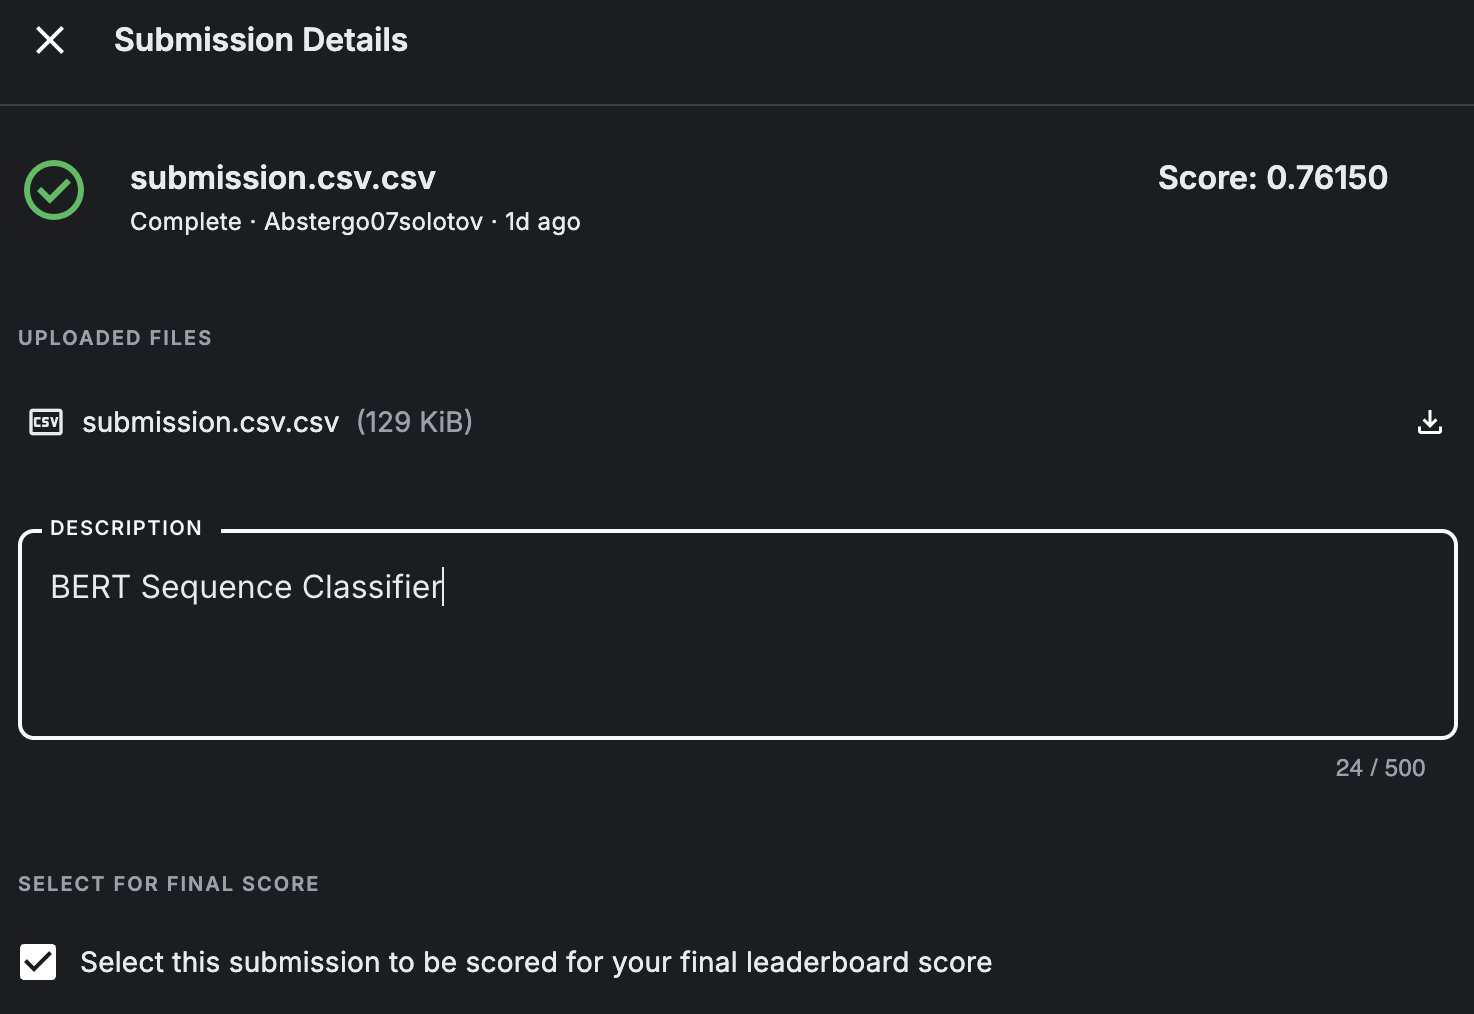

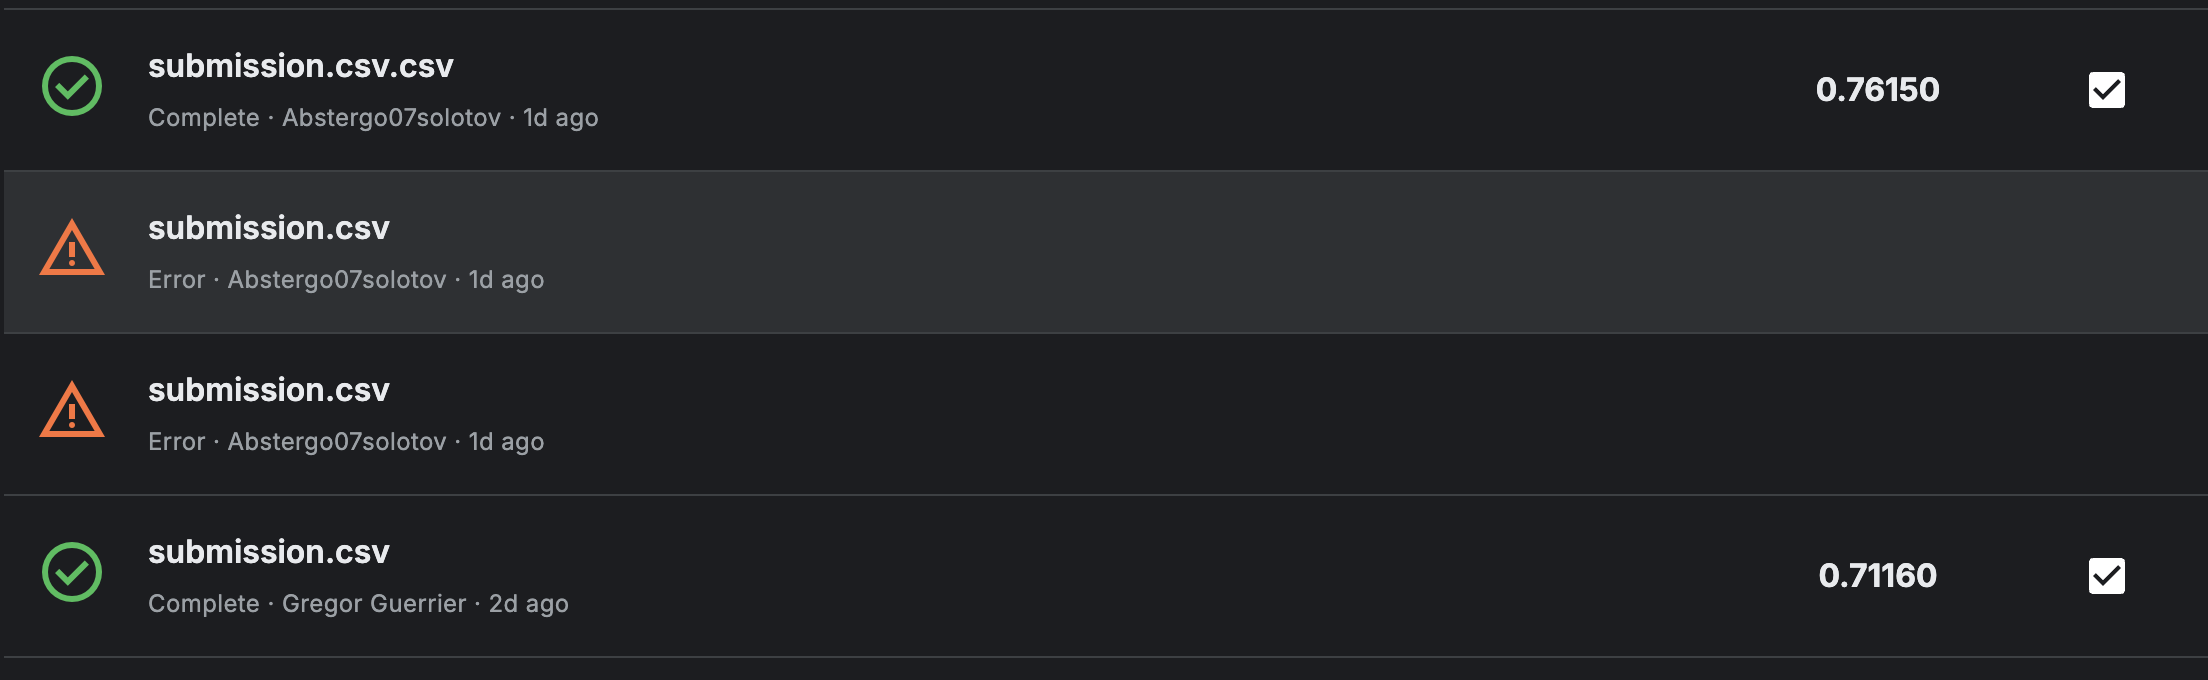

2.2.2 Please explain in detail how you achieved this and what you did specifically and why you tried this.

Step 1: loading the dataset, and then the data is split into training and test set to prepare the model for supervised learning. 

Step 2:
Tokenization: We performed tokenization to convert the textual data into a format suitable for the BERT model. This involves splitting the text into tokens, mapping tokens to indices in the BERT vocabulary, adding special tokens and peforming padding sequence to a fixed length of 128 tokens. With padding, we ensure that all sequences in a batcha are of the same legnth. After preparing the tokens we pass these into the BERT model, which has an internal embedding layer that converts them into dense vector representation. These embeddings capture semantic and contextual information. 

After tokenization, we fine-tune the pretrained BERT model on our training data, which involves updatin the weights of the pretrained model along with the newly added classification layer. For fine-tuning, we have defined the training parameter to optimaize the performance, we have used learning rate=2e-5, Batch size = 32, and fine tuned for 5 epochs. 

Step 3: 
To achieve this performance, we used bert model(bert-base-uncase) from the hugging face, which is primaryly empoyed as the base transformer model for sequence classificaiton. We have added a classification head(a fully connected layer) on top of the BERT architecture to output the predicted label for 28 classes. BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=28)

WHY BERT?
1. Contextual Understanding: BERT excels at understanding context by processing text bidirectionally.
2. Pretraining on Large Corpus: BERT has been pre-trained on vast amounts of text data, enabling it to capture nuanced language patterns, which is beneficial for downstream tasks like classification.

Step 4:
For Evaluation, we have used Accuracy and F1-score as evaluation metrics. 


<h2>Part 3: Kaggle Submission</h2><p>
You need to generate a prediction CSV using the following cell from your trained model and submit the direct output of your code to Kaggle. The results should be presented in two columns in csv format: the first column is the data id (0-14999) and the second column includes the predictions for the test set. The first column must be named id and the second column must be named label (otherwise your submission will fail). A sample predication file can be downloaded from Kaggle for each problem. 
We provide how to save a csv file if you are running Notebook on Kaggle.

In [ ]:
id = range(15000)

svm_pred = svm_model.predict(vectorized_test_text)
svm_submission = pd.DataFrame({'id': id, 'label': svm_pred})
svm_submission.to_csv('./svm_submission.csv', index=False)

nb_pred = nb_model.predict(split_processed_test_text)
nb_submission = pd.DataFrame({'id': id, 'label': nb_pred})
nb_submission.to_csv('./nb_submission.csv', index=False)

In [ ]:
#PREDICTION FOR CREATIVE PART: BERT CLASSIFIER 
#while testing with collab need to change the path to = 'test.csv' and upload the file there
test_file_path = '/kaggle/input/cs-3780-5780-how-do-you-feel/test.csv'
test_data = pd.read_csv(test_file_path)

# Add a new column for predictions
test_data['prediction'] = test_data['text'].apply(predict_sentiment)

test_data = test_data.drop(columns=['text'])

# Save the results to a new CSV
output_file_path = 'test_with_predictions.csv'
test_data.to_csv(output_file_path, index=False)

print(f"Predictions saved to {output_file_path}")

<h2>Part 4: Resources and Literature Used</h2><p>

Please cite the papers and open resources you used.

https://pythonexamples.org/python-re-sub/  \
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html \
https://towardsdatascience.com/sentiment-analysis-introduction-to-naive-bayes-algorithm-96831d77ac91
https://huggingface.co/docs/transformers/en/model_doc/bert 
https://huggingface.co/transformers/v3.0.2/model_doc/bert.html
https://medium.com/distributed-computing-with-ray/hyperparameter-optimization-for-transformers-a-guide-c4e32c6c989b
https://huggingface.co/docs/transformers/en/index
https://huggingface.co/transformers/v3.0.2/index.html
https://huggingface.co/docs/transformers/en/tasks/sequence_classification